In [1]:
import time #Checking how long they run to measure

In [2]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

In [3]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
def load_mpg():
    # fetch dataset
    auto_mpg = pd.read_csv('auto-mpg.csv').drop('car name', axis=1).replace('?', np.nan)
    
    features = ['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year', 'origin']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['mpg']
    
    # with this random seed, no null value is included in the test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test


# first impute the data and make it hypothetically clean
def load_mpg_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('auto-mpg.csv').drop('car name', axis=1).replace('?', np.nan)
    
    features = ['cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year', 'origin']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['mpg']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = load_mpg_cleaned()

In [6]:
X_train

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,8.0,350.0,125.0,3900.0,17.4,79.0,1.0
1,8.0,455.0,225.0,3086.0,10.0,70.0,1.0
2,4.0,91.0,68.0,2025.0,18.2,82.0,3.0
3,4.0,122.0,86.0,2226.0,16.5,72.0,1.0
4,4.0,97.0,67.0,2065.0,17.8,81.0,3.0
...,...,...,...,...,...,...,...
313,4.0,140.0,86.0,2790.0,15.6,82.0,1.0
314,4.0,140.0,88.0,2720.0,15.4,78.0,1.0
315,8.0,304.0,150.0,3892.0,12.5,72.0,1.0
316,4.0,97.0,75.0,2265.0,18.2,77.0,3.0


In [7]:
# useful functions

symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()


def sample_data(imputed_datasets, uncert_inds=[], seed=42):
    imp_np = np.array(imputed_datasets)
    if len(uncert_inds) == 0:
        uncert_inds = list(itertools.product(range(imp_np.shape[1]),range(imp_np.shape[2])))
    np.random.seed(seed)
    choices = np.random.choice(np.arange(imp_np.shape[0]), len(uncert_inds), replace=True)
    sample_result = imputed_datasets[0].copy()
    for i, ind in enumerate(uncert_inds):
        sample_result[ind[0]][ind[1]] = imputed_datasets[choices[i]][ind[0]][ind[1]]
    return sample_result


def linearization(expr_ls):
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        # Do not support monomial expr currently, e.g., expr = 1.5*e1. 
        # At lease two monomials in expr, e.g., expr = 1.5*e1 + 2.
        if not(expr.free_symbols):
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        for arg in expr.args:
            if not(arg.free_symbols):
                processed_expr_ls[expr_id] += arg
                continue
            p = arg.as_poly()
            monomial_exponents = p.monoms()[0]
            
            # only deal with non-linear monomials (order > 2)
            if sum(monomial_exponents) <= 1:
                processed_expr_ls[expr_id] += arg
                continue

            monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents) 
                                  if not(x in scaler_symbols))
            # check global substitution dictionary
            if monomial in linearization_dict:
                processed_expr_ls[expr_id] += arg.coeff(monomial)*linearization_dict[monomial]
            else:
                found = False
                subs_monomial = create_symbol()
                for symb in monomial.free_symbols:
                    if symb in reverse_linearization_dict:
                        equivalent_monomial = monomial.subs(symb, reverse_linearization_dict[symb])
                        if equivalent_monomial in linearization_dict:
                            subs_monomial = linearization_dict[equivalent_monomial]
                            found = True
                            break
                linearization_dict[monomial] = subs_monomial
                if not(found):
                    reverse_linearization_dict[subs_monomial] = monomial
                processed_expr_ls[expr_id] += arg.coeff(monomial)*subs_monomial
                
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def get_vertices(affset):
    l = len(affset)
    distinct_symbols = set()
    for expr in affset:
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            if distinct_symbols:
                distinct_symbols = distinct_symbols.union(expr.free_symbols)
            else:
                distinct_symbols = expr.free_symbols
    distinct_symbols = list(distinct_symbols)
    # print(distinct_symbols)
    combs = [list(zip(distinct_symbols,list(l))) for l in list(itertools.product([-1, 1], repeat=len(distinct_symbols)))]
    res = set()
    for assignment in combs:
        res.add(tuple([expr.subs(assignment) for expr in affset]))
    return(res)


# take a list of expressions as input, output the list of monomials and generator vectors,
def get_generators(expr_ls):
    monomials = dict()
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            continue
        expr = expr.expand()
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) >= 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                if len(monomials[monomial]) < expr_id:
                    monomials[monomial] = monomials[monomial] + [0 for _ in range(expr_id-len(monomials[monomial]))]
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [0 for _ in range(expr_id)] + [coef]

    for monomial in monomials:
        if len(monomials[monomial]) < len(expr_ls):
            monomials[monomial] = monomials[monomial] + [0 for _ in range(len(expr_ls)-len(monomials[monomial]))]
    
    return monomials


def plot_conretiztion(affset, alpha = 0.5, color='red', budget=-1):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1],color,alpha=alpha)

In [8]:
def inject_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = np.random.choice(range(len(y)), uncertain_num, replace=False)
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss


def sample_data_from_ranges(X, y, seed=42):
    all_free_symbols = X.free_symbols.union(y.free_symbols)
    subs_dict = dict()
    np.random.seed(seed)
    for symb in all_free_symbols:
        subs_dict[symb] = (np.random.uniform()-.5)*2
    return X.subs(subs_dict), y.subs(subs_dict)

## Verification

In [9]:
def compute_robustness_ratio(X_train, y_train, X_test, y_test, robustness_radius, uncertain_attr, 
                             uncertain_num, uncertain_radius=None, uncertain_radius_ratio=None, 
                             lr=0.1, seed=42):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr=uncertain_attr, 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=uncertain_radius_ratio, seed=seed)
    
    n = X.shape[0]
    XS = copy.deepcopy(X)
    XR = copy.deepcopy(X)
    yS = copy.deepcopy(y)
    yR = copy.deepcopy(y)

    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            expr = X[row, col]
            if isinstance(expr, sympy.Expr) and expr.free_symbols:
                XR[row, col] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
                XS[row, col] = expr - XR[row, col]
            else:
                XR[row, col] = expr
                XS[row, col] = 0

    for row in range(y.shape[0]):
        expr = y[row]
        if isinstance(expr, sympy.Expr) and expr.free_symbols:
            yR[row] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
            yS[row] = expr - yR[row]
        else:
            yR[row] = expr
            yS[row] = 0

    VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
    V = sympy.Matrix(V)

    wR = (XR.T*XR).inv()*XR.T*yR
    wS_non_data = 0.0*V.row(0).T
    for i in range(X.shape[1]):
        wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T

    eigenvalues = 1 - sigma/n*2*lr
    for eigenvalue in eigenvalues:
        try:
            assert abs(eigenvalue) <= 1
            assert eigenvalue >= 0
        except:
            print(X)
            raise ArithmeticError('Inappropriate lambda!')
    
    A = V.T*np.diag(eigenvalues)*V

    wS_data = (np.identity(X.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lr*2/n)

    wS = wS_non_data + wS_data
    w = wS + wR
    w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
    w_prime_projected = V*w_prime
    
    eqs = []
    for d in range(X.shape[1]):
        eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
        eq2 = 0
        coef_dict = dict()
        coef_dict['const'] = 0
        for i in range(X.shape[1]):
            coef_dict[sb(f'k{i}')] = 0
        for arg in w_prime_projected[d].args:
            contain_k = False
            for i in range(X.shape[1]):
                symb_k = sb(f'k{i}')
                if symb_k in arg.free_symbols:
                    coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                    contain_k = True
                    break
            if not(contain_k):
                coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
        eq2 = coef_dict['const']
        for i in range(X.shape[1]):
            eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
        eqs.append(sympy.Eq(eq1, eq2))
        
    result = sympy.solve(eqs, [sb(f'k{i}') for i in range(X.shape[1])])
    for ki in result:
        try:
            assert result[ki] >= 0
        except:
            print(result)
            print(eqs)
            raise ArithmeticError('Negative k!')
    param = wR + wS.subs(result)
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)


# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)
    

### Uncertain Labels

**Zonotope + Label Error**

In [10]:
start_time = time.time()

In [11]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 654.5839183330536 seconds


**Interval + Label Error**

In [13]:
start_time = time.time()

In [14]:
robustness_dicts_interval = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 188.16305303573608 seconds


In [16]:
pd.DataFrame(robustness_dicts_interval[0])

,uncertain_radius,uncertain_radius_ratios,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,1.88,0.05,1.000,1.0000,1.0000,0.9750,0.8750,0.675,0.6000,0.5500,0.4250,0.3750
1,3.76,0.10,1.000,1.0000,0.8875,0.6125,0.3750,0.200,0.1125,0.0875,0.0625,0.0375
2,5.64,0.15,1.000,0.9375,0.5625,0.3125,0.1125,0.050,0.0250,0.0000,0.0000,0.0000
3,7.52,0.20,1.000,0.7375,0.3375,0.1375,0.0375,0.000,0.0000,0.0000,0.0000,0.0000
4,9.40,0.25,0.975,0.5375,0.2000,0.0500,0.0000,0.000,0.0000,0.0000,0.0000,0.0000


In [17]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)


In [18]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


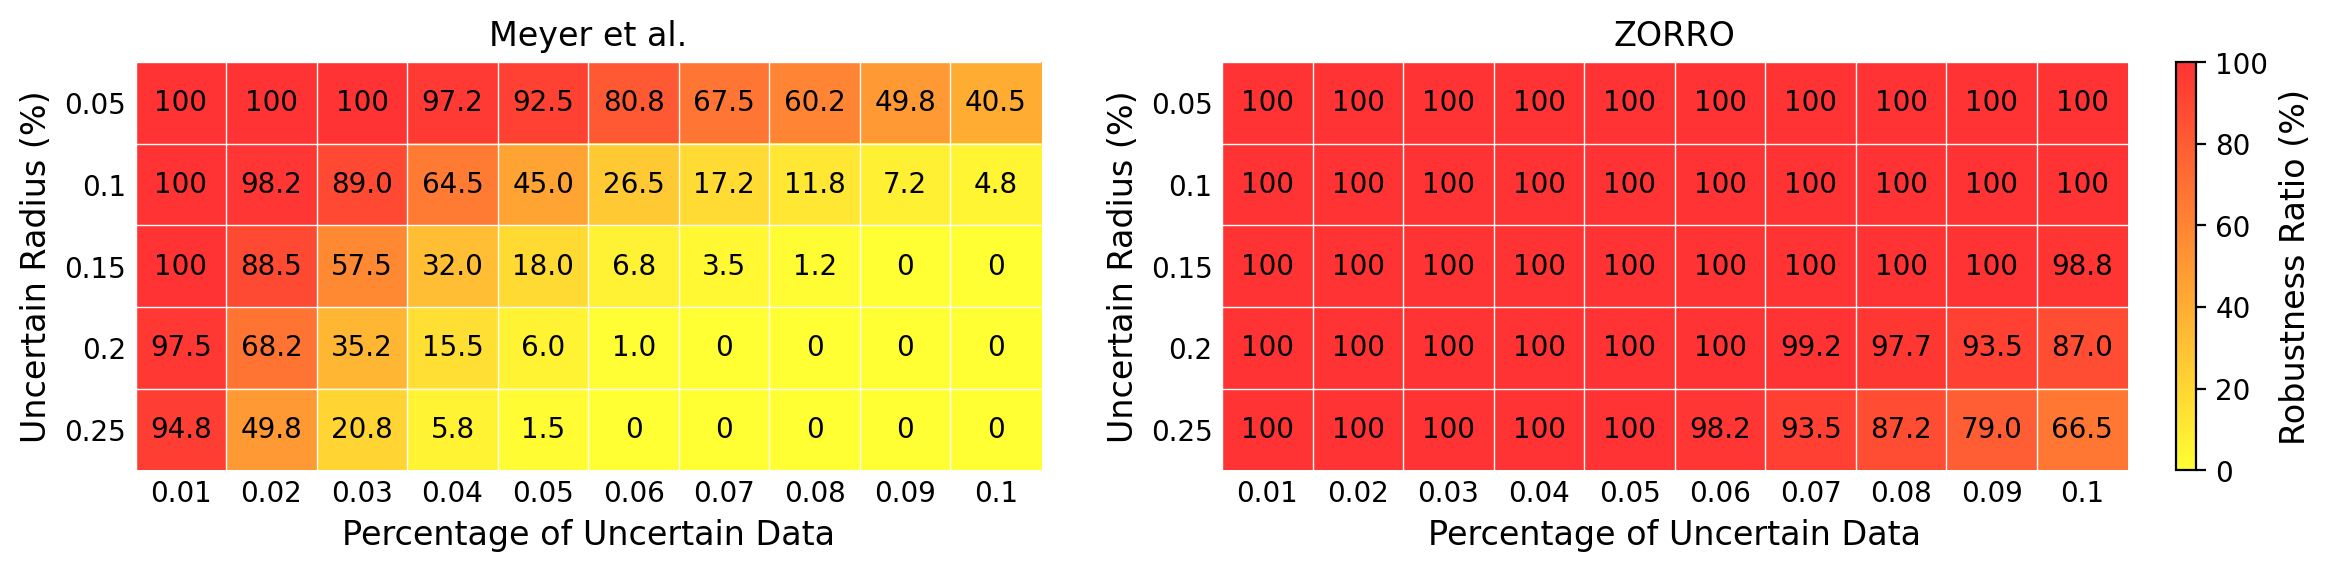

In [19]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('mpg-heatmap.pdf', bbox_inches='tight')

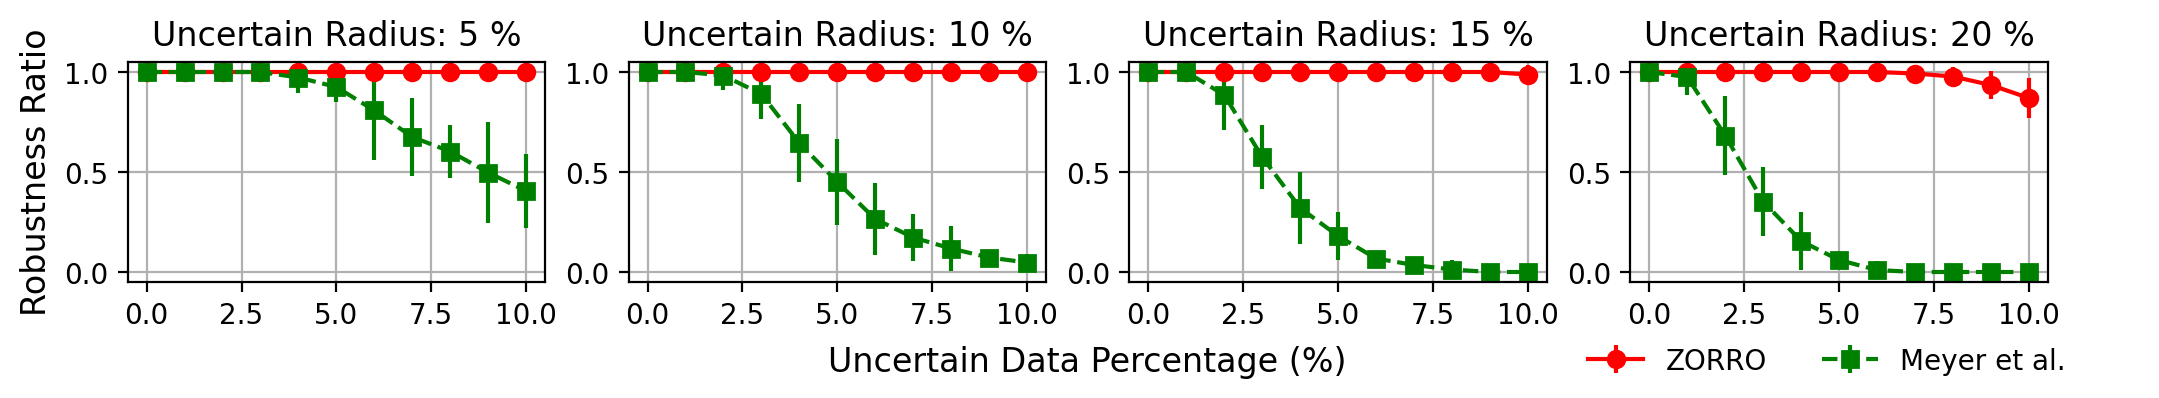

In [20]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-labels-lineplot.pdf', bbox_inches='tight')

### Uncertain Features

In [21]:
start_time = time.time()

In [22]:
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    weight_interval = X_train.weight.max()-X_train.weight.min()
    uncertain_radius_ratios = [0.06, 0.08, 0.10, 0.12]
    uncertain_radiuses = [ratio*weight_interval for ratio in uncertain_radius_ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = uncertain_radius_ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius_ratio in tqdm(uncertain_radius_ratios, desc=f'Uncertain Data PCT: {uncertain_pct}'):
            robustness_ratio = compute_robustness_ratio(X_train, y_train, X_test, y_test, 
                                                        uncertain_attr='weight', 
                                                        uncertain_num=uncertain_num, 
                                                        uncertain_radius_ratio=uncertain_radius_ratio, 
                                                        robustness_radius=robustness_radius, seed=seed)
            if robustness_ratio==0:
                trials_left = len(uncertain_radius_ratios)-uncertain_radius_ratios.index(uncertain_radius_ratio)
                for _ in range(trials_left):
                    robustness_dict[uncertain_pct].append(0)
                break
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 2971.58549952507 seconds


In [24]:
pd.DataFrame(robustness_dicts[0])

,uncertain_radius,uncertain_radius_ratios,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,211.62,0.06,1.0,1.0,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,282.16,0.08,1.0,1.0,1.0,1.0,1.0000,1.0000,1.0000,0.9875,0.9875,0.9750
2,352.70,0.10,1.0,1.0,1.0,1.0,1.0000,0.9875,0.9750,0.8250,0.6625,0.3625
3,423.24,0.12,1.0,1.0,1.0,1.0,0.9875,0.7875,0.5625,0.2375,0.0000,0.0000


In [25]:
pd.DataFrame(robustness_dicts[1])

,uncertain_radius,uncertain_radius_ratios,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,211.62,0.06,1.0,1.0,1.0,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.000
1,282.16,0.08,1.0,1.0,1.0,1.0,1.0,1.0000,1.0000,1.0000,1.0000,0.975
2,352.70,0.10,1.0,1.0,1.0,1.0,1.0,1.0000,0.9875,0.9375,0.8000,0.600
3,423.24,0.12,1.0,1.0,1.0,1.0,1.0,0.9375,0.7750,0.5000,0.1625,0.000


In [26]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)


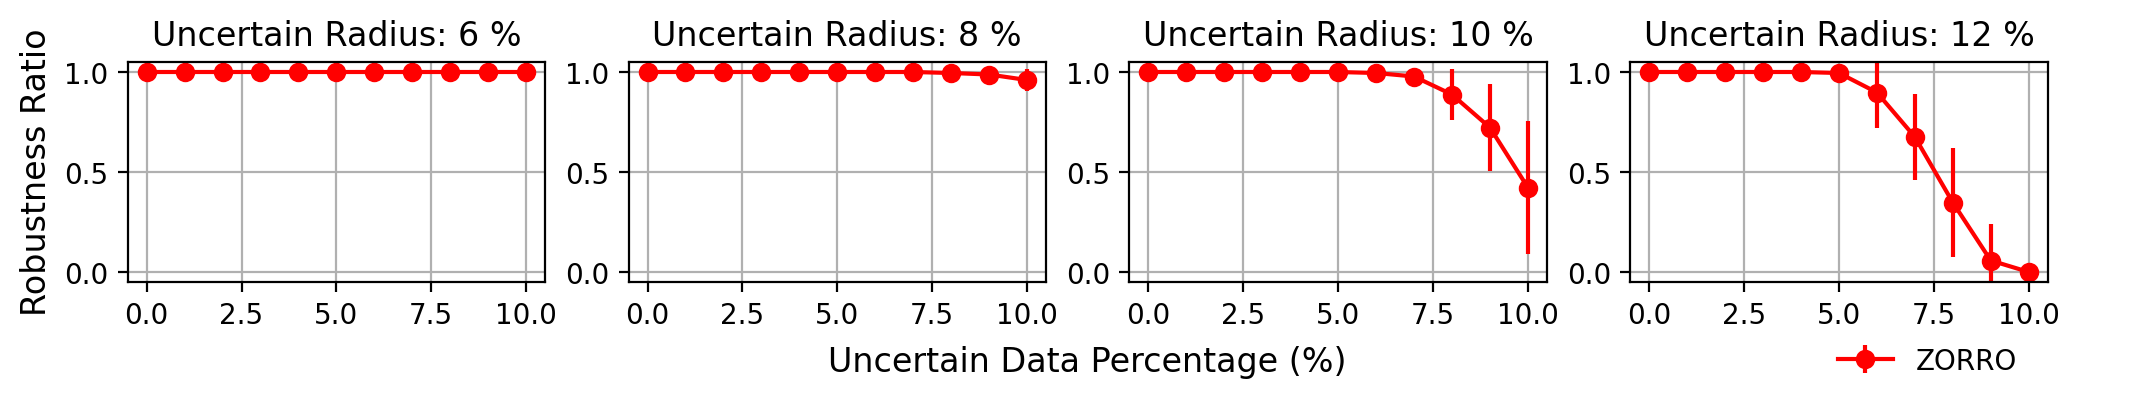

In [27]:
from matplotlib.ticker import FormatStrFormatter
uncertain_pcts = (np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100)
# uncertain_radius_ratios = [0.06, 0.08, 0.10, 0.12]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius = uncertain_radiuses[i]
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    radius_title = str(int(uncertain_radius_ratio*100))
    if uncertain_radius_ratio == 0.1:
        radius_title = '10'
    axes[i].set_title(f'Uncertain Radius: {radius_title} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.85, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('mpg-features-lineplot.pdf', bbox_inches='tight')

## Regularization

In [10]:
# use interval hull for order reduction
def compute_robustness_ratio_IH(X_train, y_train, X_test, y_test, robustness_radius, uncertain_attr, 
                                uncertain_num, uncertain_radius=None, uncertain_radius_ratio=None, 
                                lamb=0.1, seed=42):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr=uncertain_attr, 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=uncertain_radius_ratio, seed=seed)
    
    n = X.shape[0]
    XS = copy.deepcopy(X)
    XR = copy.deepcopy(X)
    yS = copy.deepcopy(y)
    yR = copy.deepcopy(y)

    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            expr = X[row, col]
            if isinstance(expr, sympy.Expr) and expr.free_symbols:
                XR[row, col] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
                XS[row, col] = expr - XR[row, col]
            else:
                XR[row, col] = expr
                XS[row, col] = 0

    for row in range(y.shape[0]):
        expr = y[row]
        if isinstance(expr, sympy.Expr) and expr.free_symbols:
            yR[row] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
            yS[row] = expr - yR[row]
        else:
            yR[row] = expr
            yS[row] = 0

    sigma = np.ones(X.shape[1])
    V = sympy.Matrix(np.identity(X.shape[1]))

    wR = (XR.T*XR).inv()*XR.T*yR
    wS_non_data = 0.0*XR.row(0).T
    for i in range(X.shape[1]):
        wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T
    
    eigenvalues = 1 - sigma/n*2*lamb
    for eigenvalue in eigenvalues:
        assert abs(eigenvalue) <= 1
    
    A = V.T*np.diag(eigenvalues)*V

    wS_data = (np.identity(X.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lamb*2/n)

    wS = wS_non_data + wS_data
    w = wS + wR
    w_prime = (-lamb*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
    w_prime_projected = V*w_prime
    
    eqs = []
    for d in range(X.shape[1]):
        eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
        eq2 = 0
        coef_dict = dict()
        coef_dict['const'] = 0
        for i in range(X.shape[1]):
            coef_dict[sb(f'k{i}')] = 0
        for arg in w_prime_projected[d].args:
            contain_k = False
            for i in range(X.shape[1]):
                symb_k = sb(f'k{i}')
                if symb_k in arg.free_symbols:
                    coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                    contain_k = True
                    break
            if not(contain_k):
                coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
        eq2 = coef_dict['const']
        for i in range(X.shape[1]):
            eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
        eqs.append(sympy.Eq(eq1, eq2))
        
    result = sympy.solve(eqs, [sb(f'k{i}') for i in range(X.shape[1])])
    print(eqs)
    print(result)
    param = wR + wS.subs(result)
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)


In [11]:
def min_max_sympy_expression(expr):
    """
    Calculates the minimum and maximum values of a second order polynomial 
    expression with one symbol, where the symbol ranges from -1 to 1.
    
    Args:
    expr (sympy.Expr): A SymPy expression.
    
    Returns:
    tuple: (minimum value, maximum value) of the expression over the interval [-1, 1].
    """
    # Extract the symbol from the expression
    if len(expr.free_symbols) != 1:
        raise ValueError("The expression must contain exactly one symbol.")
    
    symbol = list(expr.free_symbols)[0]
    
    # Derivative of the expression
    df = sympy.diff(expr, symbol)
    
    # Find critical points
    critical_points = sympy.solveset(df, symbol, domain=sympy.Interval(-1, 1))
    
    # Evaluate the expression at critical points and at the interval boundaries
    critical_values = [expr.subs(symbol, cp) for cp in critical_points]
    boundary_values = [expr.subs(symbol, b) for b in [-1, 1]]
    
    # Combine all values to determine the min and max
    all_values = critical_values + boundary_values
    min_value = min(all_values)
    max_value = max(all_values)
    
    return min_value, max_value


# Example usage:
x = sympy.symbols('x')
expr = x**2 - 2*x + 1
min_val, max_val = min_max_sympy_expression(expr)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Minimum Value: 0
Maximum Value: 4


In [12]:
def get_expr_range_radius(expr):
    expr_range_radius = 0
    for arg in expr.args:
        if arg.free_symbols:
            expr_range_radius += abs(arg.args[0])
    return expr_range_radius

def get_expr_center(expr):
    return expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
    
def compute_robustness_ratio_reg(X_train, y_train, X_test, y_test, robustness_radius, uncertain_attr, 
                                 uncertain_num, uncertain_radius=None, uncertain_radius_ratio=None, 
                                 lr=0.03, reg=0, seed=42):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr=uncertain_attr, 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=uncertain_radius_ratio, seed=seed)
    
    n = X.shape[0]
    XS = copy.deepcopy(X)
    XR = copy.deepcopy(X)
    yS = copy.deepcopy(y)
    yR = copy.deepcopy(y)
    y_test = sympy.Matrix(y_test.to_numpy().reshape(-1, 1))
    X_test = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))

    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            expr = X[row, col]
            if isinstance(expr, sympy.Expr) and expr.free_symbols:
                XR[row, col] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
                XS[row, col] = expr - XR[row, col]
            else:
                XR[row, col] = expr
                XS[row, col] = 0

    for row in range(y.shape[0]):
        expr = y[row]
        if isinstance(expr, sympy.Expr) and expr.free_symbols:
            yR[row] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
            yS[row] = expr - yR[row]
        else:
            yR[row] = expr
            yS[row] = 0
    
    common_inv = (XR.T*XR + reg*n*np.identity(X.shape[1])).inv()
    
    V, sigma, VT = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
    V = sympy.Matrix(V)
    VT = sympy.Matrix(VT)

    wR = common_inv*XR.T*yR
    wS_data = common_inv*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)
    wS_non_data = 0.0*VT.row(0).T
    for i in range(X.shape[1]):
        wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*VT.row(i).T

    eigenvalues = 1 - 2*lr*reg - 2*lr*sigma/n
    for eigenvalue in eigenvalues:
        assert eigenvalue <= 1
        assert eigenvalue >= 0
    
    wS = wS_non_data + wS_data
    w = wS + wR
    w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
    w_prime_projected = VT*w_prime
    
    eqs = []
    for d in range(X.shape[1]):
        eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
        eq2 = 0
        coef_dict = dict()
        coef_dict['const'] = 0
        for i in range(X.shape[1]):
            coef_dict[sb(f'k{i}')] = 0
        for arg in w_prime_projected[d].args:
            contain_k = False
            for i in range(X.shape[1]):
                symb_k = sb(f'k{i}')
                if symb_k in arg.free_symbols:
                    coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                    contain_k = True
                    break
            if not(contain_k):
                coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
        eq2 = coef_dict['const']
        for i in range(X.shape[1]):
            eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
        eqs.append(sympy.Eq(eq1, eq2))
        
    result = sympy.solve(eqs, [sb(f'k{i}') for i in range(X.shape[1])])
    for ki in result:
        assert result[ki] >= 0
    param = wR + wS.subs(result)
    
    center_preds = X_test*get_expr_center(param)
    print('one-poss-world:', [((center_preds - y_test).T*(center_preds - y_test)/n)[0]])
    
    test_preds = X_test*param
    robustness_ls = []
#     se_min_ls = []
#     se_max_ls = []
    for pred_id, pred in enumerate(test_preds):
        label_test = y_test[pred_id]
        pred_range_radius = get_expr_range_radius(pred)
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
#         pred_center = get_expr_center(pred)
#         rewrite_pred = pred_center+pred_range_radius*sb('err_pred')
#         se_min, se_max = min_max_sympy_expression((rewrite_pred-label_test)**2)
#         se_min_ls.append(se_min)
#         se_max_ls.append(se_max)
    preds_diff = linearization([((test_preds - y_test).T*(test_preds - y_test)/n)[0]])[0]
    preds_diff_center = get_expr_center(preds_diff)
    preds_diff_radius = get_expr_range_radius(preds_diff)
#     print(preds_diff_center)
#     print(preds_diff_radius)
    
#     print(param)
    return np.mean(robustness_ls), preds_diff_center - preds_diff_radius, \
           preds_diff_center + preds_diff_radius


### Uncertain Labels

In [31]:
start_time = time.time()

In [32]:
robustness_ratio_dicts = []
max_mse_dicts = []
min_mse_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    # uncertain label +- 10
    uncertain_radius = 10
    uncertain_pcts = [0.08, 0.10, 0.12, 0.14]
    # regs = [0, 0.001, 0.003, 0.01, 0.03]
    regs = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]

    robustness_ratio_dict = dict()
    max_mse_dict = dict()
    min_mse_dict = dict()
    # robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_ratio_dict['Reg. Coef.'] = regs
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_ratio_dict[uncertain_pct] = list()
        max_mse_dict[uncertain_pct] = list()
        min_mse_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for reg in tqdm(regs, desc=f'Varying Regularization Coefficient'):
            res = compute_robustness_ratio_reg(X_train, y_train, X_test, y_test, 
                                               uncertain_attr='y', uncertain_num=uncertain_num, 
                                               uncertain_radius=uncertain_radius, 
                                               robustness_radius=robustness_radius, 
                                               reg=reg, seed=seed)
            robustness_ratio, min_mse, max_mse = res
            print(res)
            robustness_ratio_dict[uncertain_pct].append(robustness_ratio)
            max_mse_dict[uncertain_pct].append(max_mse)
            min_mse_dict[uncertain_pct].append(min_mse)
    robustness_ratio_dicts.append(robustness_ratio_dict)
    max_mse_dicts.append(max_mse_dict)
    min_mse_dicts.append(min_mse_dict)

Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.825, 1.28055036425234, 2.59009159697269)
one-poss-world: [1.94280212875598]
(0.825, 1.29555815043546, 2.59004610707651)
one-poss-world: [1.95728486456244]
(0.825, 1.31097905115891, 2.60359067796597)
one-poss-world: [1.97819786772122]
(0.8625, 1.32730681332948, 2.62908892211296)
one-poss-world: [2.00525926677026]
(0.8625, 1.34292863550359, 2.66758989803692)
one-poss-world: [2.03829695460416]
(0.875, 1.36019084629971, 2.71640306290862)
one-poss-world: [2.07717879672616]
(0.8875, 1.38079813714375, 2.77355945630856)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.525, 1.10477649775506, 2.76586546346997)
one-poss-world: [1.94280212875598]
(0.5625, 1.13598311961051, 2.74962113790146)
one-poss-world: [1.95728486456244]
(0.6, 1.16585988348375, 2.74870984564114)
one-poss-world: [1.97819786772122]
(0.6375, 1.19539384065483, 2.76100189478761)
one-poss-world: [2.00525926677026]
(0.6875, 1.21931658859081, 2.79120194494970)
one-poss-world: [2.03829695460416]
(0.7125, 1.23721455467466, 2.83937935453367)
one-poss-world: [2.07717879672616]
(0.725, 1.25800067747787, 2.89635691597445)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.15, 0.727313417489940, 3.14332854373509)
one-poss-world: [1.94280212875598]
(0.1625, 0.768968310225549, 3.11663594728642)
one-poss-world: [1.95728486456244]
(0.2375, 0.807457636897024, 3.10711209222786)
one-poss-world: [1.97819786772122]
(0.25, 0.843302302669575, 3.11309343277287)
one-poss-world: [2.00525926677026]
(0.25, 0.871121232589150, 3.13939730095137)
one-poss-world: [2.03829695460416]
(0.275, 0.890597001647393, 3.18599690756094)
one-poss-world: [2.07717879672616]
(0.3, 0.911880904161893, 3.24247668929042)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0625, 0.400783600312755, 3.46985836091228)
one-poss-world: [1.94280212875598]
(0.0625, 0.447388984528396, 3.43821527298357)
one-poss-world: [1.95728486456244]
(0.0625, 0.488592965401954, 3.42597676372293)
one-poss-world: [1.97819786772122]
(0.075, 0.525731040989752, 3.43066469445269)
one-poss-world: [2.00525926677026]
(0.075, 0.553645150385453, 3.45687338315506)
one-poss-world: [2.03829695460416]
(0.075, 0.572932771112296, 3.50366113809603)
one-poss-world: [2.07717879672616]
(0.0875, 0.593207462253185, 3.56115013119913)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.8625, 1.16921743883460, 2.70142452239043)
one-poss-world: [1.94280212875598]
(0.8875, 1.22324877470657, 2.66235548280540)
one-poss-world: [1.95728486456244]
(0.9, 1.27697692706452, 2.63759280206036)
one-poss-world: [1.97819786772122]
(0.9, 1.32592006377807, 2.63047567166437)
one-poss-world: [2.00525926677026]
(0.9125, 1.37503627541913, 2.63548225812139)
one-poss-world: [2.03829695460416]
(0.9125, 1.41988858180660, 2.65670532740173)
one-poss-world: [2.07717879672616]
(0.9125, 1.45616918304933, 2.69818841040299)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.5875, 1.01900752317093, 2.85163443805410)
one-poss-world: [1.94280212875598]
(0.6125, 1.06570022278641, 2.81990403472555)
one-poss-world: [1.95728486456244]
(0.65, 1.11349957898708, 2.80107015013780)
one-poss-world: [1.97819786772122]
(0.6875, 1.15739042157738, 2.79900531386506)
one-poss-world: [2.00525926677026]
(0.7, 1.20168381976954, 2.80883471377097)
one-poss-world: [2.03829695460416]
(0.7125, 1.24211136462036, 2.83448254458797)
one-poss-world: [2.07717879672616]
(0.7625, 1.27421903904600, 2.88013855440631)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.2, 0.733078820189072, 3.13756314103596)
one-poss-world: [1.94280212875598]
(0.25, 0.788097359167097, 3.09750689834487)
one-poss-world: [1.95728486456244]
(0.275, 0.843590602602299, 3.07097912652259)
one-poss-world: [1.97819786772122]
(0.275, 0.893862572842572, 3.06253316259987)
one-poss-world: [2.00525926677026]
(0.3, 0.944057933754565, 3.06646059978595)
one-poss-world: [2.03829695460416]
(0.325, 0.989790286217465, 3.08680362299086)
one-poss-world: [2.07717879672616]
(0.35, 1.02657439785346, 3.12778319559885)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.075, 0.577004691554629, 3.29363726967040)
one-poss-world: [1.94280212875598]
(0.075, 0.634513808791827, 3.25109044872014)
one-poss-world: [1.95728486456244]
(0.0875, 0.689726457066778, 3.22484327205811)
one-poss-world: [1.97819786772122]
(0.0875, 0.738013418710821, 3.21838231673162)
one-poss-world: [2.00525926677026]
(0.1, 0.785971796116817, 3.22454673742370)
one-poss-world: [2.03829695460416]
(0.125, 0.828880614103006, 3.24771329510532)
one-poss-world: [2.07717879672616]
(0.1375, 0.858694158435560, 3.29566343501675)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.825, 1.25450001439985, 2.61614194682519)
one-poss-world: [1.94280212875598]
(0.85, 1.28084518188284, 2.60475907562913)
one-poss-world: [1.95728486456244]
(0.8625, 1.30886073464178, 2.60570899448310)
one-poss-world: [1.97819786772122]
(0.875, 1.33606039618796, 2.62033533925448)
one-poss-world: [2.00525926677026]
(0.9125, 1.36717385237755, 2.64334468116297)
one-poss-world: [2.03829695460416]
(0.925, 1.39908198084021, 2.67751192836812)
one-poss-world: [2.07717879672616]
(0.95, 1.42827015593832, 2.72608743751399)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.5375, 1.02669866571413, 2.84394329551090)
one-poss-world: [1.94280212875598]
(0.5875, 1.05473642205400, 2.83086783545797)
one-poss-world: [1.95728486456244]
(0.6125, 1.08409434926434, 2.83047537986055)
one-poss-world: [1.97819786772122]
(0.6125, 1.11268115115226, 2.84371458429018)
one-poss-world: [2.00525926677026]
(0.625, 1.14514256610601, 2.86537596743450)
one-poss-world: [2.03829695460416]
(0.6375, 1.17419378555163, 2.90240012365670)
one-poss-world: [2.07717879672616]
(0.65, 1.19720575771665, 2.95715183573566)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.2375, 0.800961084245648, 3.06968087697938)
one-poss-world: [1.94280212875598]
(0.2625, 0.834284994667461, 3.05131926284450)
one-poss-world: [1.95728486456244]
(0.275, 0.868579619196844, 3.04599010992804)
one-poss-world: [1.97819786772122]
(0.3125, 0.896689433405258, 3.05970630203718)
one-poss-world: [2.00525926677026]
(0.375, 0.923226042051432, 3.08729249148908)
one-poss-world: [2.03829695460416]
(0.3875, 0.946346814023471, 3.13024709518486)
one-poss-world: [2.07717879672616]
(0.4, 0.963271334224379, 3.19108625922793)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.1375, 0.634114723453208, 3.23652723777182)
one-poss-world: [1.94280212875598]
(0.15, 0.670380256297800, 3.21522400121416)
one-poss-world: [1.95728486456244]
(0.15, 0.707373244061499, 3.20719648506339)
one-poss-world: [1.97819786772122]
(0.15, 0.736119592778494, 3.22027614266395)
one-poss-world: [2.00525926677026]
(0.1625, 0.762611863288386, 3.24790667025213)
one-poss-world: [2.03829695460416]
(0.175, 0.786043410802426, 3.29055049840590)
one-poss-world: [2.07717879672616]
(0.1875, 0.803658566374771, 3.35069902707754)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.875, 1.38302864483815, 2.48761331638689)
one-poss-world: [1.94280212875598]
(0.875, 1.39076022934213, 2.49484402816984)
one-poss-world: [1.95728486456244]
(0.9, 1.39808475882766, 2.51648497029723)
one-poss-world: [1.97819786772122]
(0.9125, 1.40270039600493, 2.55369533943751)
one-poss-world: [2.00525926677026]
(0.9375, 1.41024839444656, 2.60027013909395)
one-poss-world: [2.03829695460416]
(0.9375, 1.41764026447266, 2.65895364473567)
one-poss-world: [2.07717879672616]
(0.9625, 1.43116829486022, 2.72318929859209)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.625, 1.25126049968473, 2.61938146154030)
one-poss-world: [1.94280212875598]
(0.65, 1.26216162838110, 2.62344262913086)
one-poss-world: [1.95728486456244]
(0.7, 1.27306054692731, 2.64150918219758)
one-poss-world: [1.97819786772122]
(0.7375, 1.28137562509039, 2.67502011035205)
one-poss-world: [2.00525926677026]
(0.7875, 1.28487244739586, 2.72564608614466)
one-poss-world: [2.03829695460416]
(0.8, 1.28707378972831, 2.78952011948002)
one-poss-world: [2.07717879672616]
(0.8125, 1.29535071416034, 2.85900687929197)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.225, 0.916345906610961, 2.95429605461407)
one-poss-world: [1.94280212875598]
(0.225, 0.929178974406291, 2.95642528310567)
one-poss-world: [1.95728486456244]
(0.25, 0.937633635328111, 2.97693609379677)
one-poss-world: [1.97819786772122]
(0.275, 0.942152812083535, 3.01424292335891)
one-poss-world: [2.00525926677026]
(0.35, 0.941258365383807, 3.06926016815671)
one-poss-world: [2.03829695460416]
(0.3875, 0.934476636633817, 3.14211727257451)
one-poss-world: [2.07717879672616]
(0.4, 0.933856901110675, 3.22050069234164)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.075, 0.743217633428116, 3.12742432779692)
one-poss-world: [1.94280212875598]
(0.1, 0.750939543835758, 3.13466471367621)
one-poss-world: [1.95728486456244]
(0.1, 0.757415150356835, 3.15715457876805)
one-poss-world: [1.97819786772122]
(0.1125, 0.760374386872079, 3.19602134857036)
one-poss-world: [2.00525926677026]
(0.1125, 0.755365956190936, 3.25515257734958)
one-poss-world: [2.03829695460416]
(0.1125, 0.741194292007542, 3.33539961720079)
one-poss-world: [2.07717879672616]
(0.1125, 0.732823113485182, 3.42153447996713)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.8, 1.20332292086009, 2.66731904036495)
one-poss-world: [1.94280212875598]
(0.8125, 1.23916397797086, 2.64644027954111)
one-poss-world: [1.95728486456244]
(0.8375, 1.27073864206027, 2.64383108706462)
one-poss-world: [1.97819786772122]
(0.85, 1.30122123936302, 2.65517449607942)
one-poss-world: [2.00525926677026]
(0.8875, 1.32564254385909, 2.68487598968142)
one-poss-world: [2.03829695460416]
(0.8875, 1.35021014077549, 2.72638376843283)
one-poss-world: [2.07717879672616]
(0.9375, 1.37935589630669, 2.77500169714562)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.5625, 1.00866259207352, 2.86197936915151)
one-poss-world: [1.94280212875598]
(0.625, 1.05101864316469, 2.83458561434727)
one-poss-world: [1.95728486456244]
(0.6375, 1.08431412317448, 2.83025560595040)
one-poss-world: [1.97819786772122]
(0.6375, 1.11534839100632, 2.84104734443612)
one-poss-world: [2.00525926677026]
(0.6625, 1.13968792316917, 2.87083061037135)
one-poss-world: [2.03829695460416]
(0.6875, 1.16255747497356, 2.91403643423476)
one-poss-world: [2.07717879672616]
(0.725, 1.18915821856875, 2.96519937488356)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.175, 0.739768732988275, 3.13087322823676)
one-poss-world: [1.94280212875598]
(0.2125, 0.782542714284653, 3.10306154322731)
one-poss-world: [1.95728486456244]
(0.2125, 0.815021690678673, 3.09954803844621)
one-poss-world: [1.97819786772122]
(0.225, 0.841564029089949, 3.11483170635249)
one-poss-world: [2.00525926677026]
(0.25, 0.855586089075202, 3.15493244446531)
one-poss-world: [2.03829695460416]
(0.3, 0.868189572250771, 3.20840433695756)
one-poss-world: [2.07717879672616]
(0.35, 0.883878515299292, 3.27047907815302)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0375, 0.545036934099701, 3.32560502712533)
one-poss-world: [1.94280212875598]
(0.05, 0.579108977210539, 3.30649528030143)
one-poss-world: [1.95728486456244]
(0.075, 0.604782402761523, 3.30978732636336)
one-poss-world: [1.97819786772122]
(0.075, 0.624079447471401, 3.33231628797104)
one-poss-world: [2.00525926677026]
(0.075, 0.630754129786373, 3.37976440375414)
one-poss-world: [2.03829695460416]
(0.125, 0.636045832865051, 3.44054807634328)
one-poss-world: [2.07717879672616]
(0.1375, 0.644845176303887, 3.50951241714843)


In [33]:
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 5400.774076700211 seconds


In [34]:
robustness_ratio_zonotope_mean = (sum([pd.DataFrame(robustness_ratio_dicts[i]).iloc[:, 1:] for i in range(5)])/5).astype(float)
robustness_ratio_zonotope_std = (sum([(pd.DataFrame(robustness_ratio_dicts[i]).iloc[:, 1:]-robustness_ratio_zonotope_mean)**2 for i in range(5)])/5).astype(float).apply(np.sqrt)
max_mse_zonotope_mean = (sum([pd.DataFrame(max_mse_dicts[i]) for i in range(5)])/5).astype(float)
max_mse_zonotope_std = (sum([(pd.DataFrame(max_mse_dicts[i])-max_mse_zonotope_mean)**2 for i in range(5)])/5).astype(float).apply(np.sqrt)


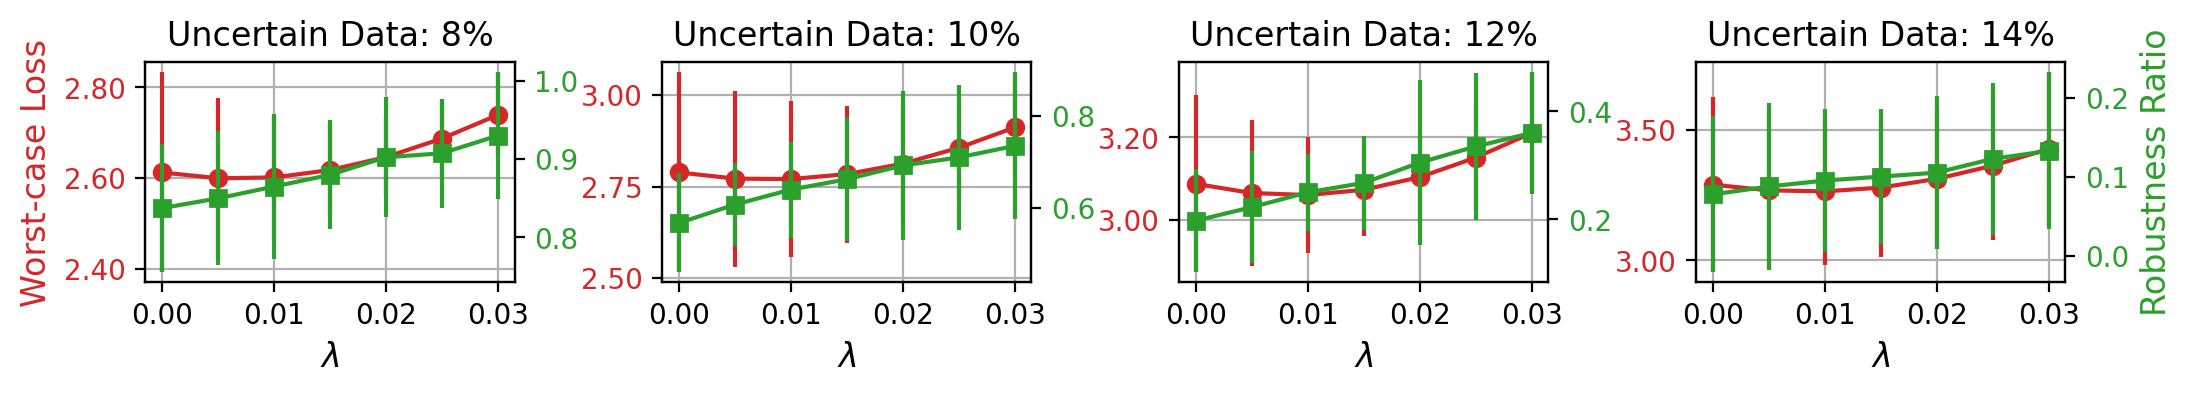

In [35]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)
color1 = 'tab:red'
color2 = 'tab:green'

for i in range(4):
    ax1 = axes[i]
    ax1.set_xlabel('$\lambda$', fontsize=12)
    if i==0:
        ax1.set_ylabel('Worst-case Loss', color=color1, fontsize=12)
    ax1.errorbar(regs, max_mse_zonotope_mean.iloc[:, i].values,
                 yerr=3*max_mse_zonotope_std.iloc[:, i],
                 color=color1, marker='o', linestyle='-')
#     ax1.plot(regs, pd.DataFrame(max_mse_dict)[uncertain_pcts[i]], color=color1, marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()

    if i==3:
        ax2.set_ylabel('Robustness Ratio', color=color2, fontsize=12)
    ax2.errorbar(regs, robustness_ratio_zonotope_mean.iloc[:, i].values,
                 yerr=3*robustness_ratio_zonotope_std.iloc[:, i],
                 color=color2, marker='s', linestyle='-')
#     ax2.plot(regs, (pd.DataFrame(robustness_ratio_dict))[uncertain_pcts[i]], color=color2, marker='s')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f'Uncertain Data: {int(uncertain_pcts[i]*100)}%')
    ax1.grid(True)
#     ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
plt.subplots_adjust(wspace=0.4, top=0.8, bottom=0.25, left=0.1, right=0.9)
plt.savefig('mpg-regularization-labels-3sigma-lineplot.pdf', bbox_inches='tight')


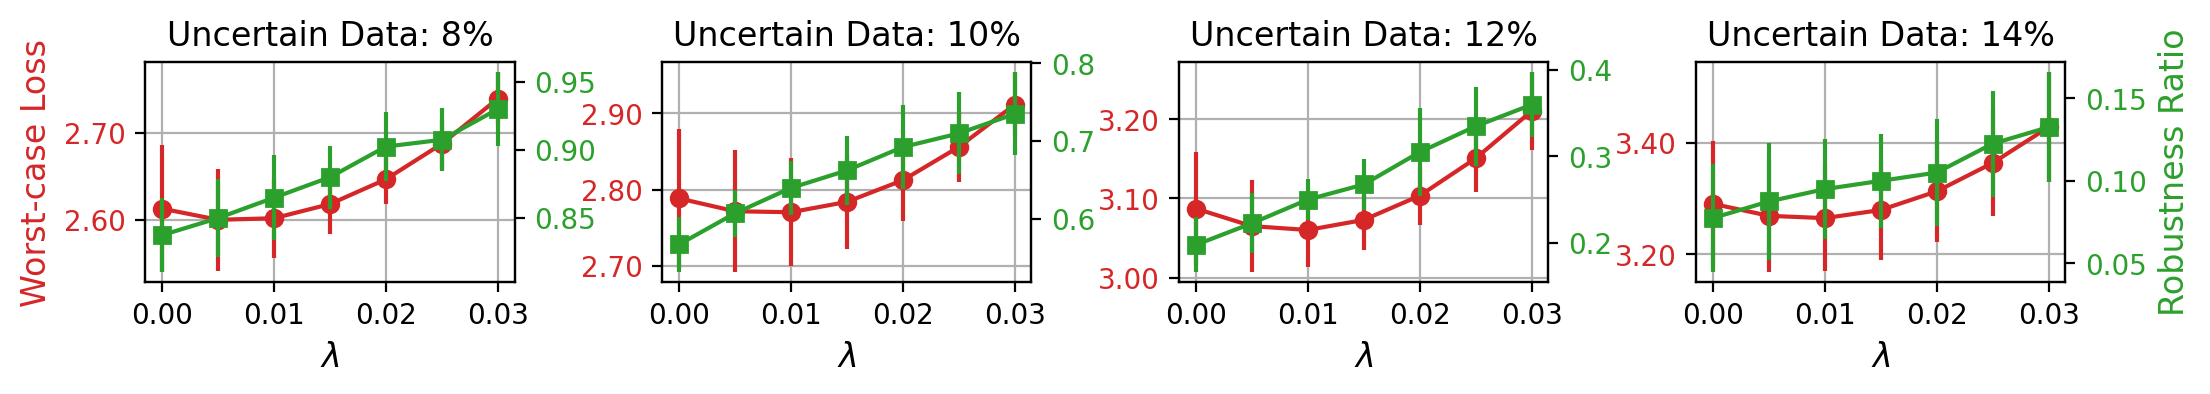

In [36]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)
color1 = 'tab:red'
color2 = 'tab:green'

for i in range(4):
    ax1 = axes[i]
    ax1.set_xlabel('$\lambda$', fontsize=12)
    if i==0:
        ax1.set_ylabel('Worst-case Loss', color=color1, fontsize=12)
    ax1.errorbar(regs, max_mse_zonotope_mean.iloc[:, i].values,
                 yerr=max_mse_zonotope_std.iloc[:, i],
                 color=color1, marker='o', linestyle='-')
#     ax1.plot(regs, pd.DataFrame(max_mse_dict)[uncertain_pcts[i]], color=color1, marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()

    if i==3:
        ax2.set_ylabel('Robustness Ratio', color=color2, fontsize=12)
    ax2.errorbar(regs, robustness_ratio_zonotope_mean.iloc[:, i].values,
                 yerr=robustness_ratio_zonotope_std.iloc[:, i],
                 color=color2, marker='s', linestyle='-')
#     ax2.plot(regs, (pd.DataFrame(robustness_ratio_dict))[uncertain_pcts[i]], color=color2, marker='s')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f'Uncertain Data: {int(uncertain_pcts[i]*100)}%')
    ax1.grid(True)
#     ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
plt.subplots_adjust(wspace=0.4, top=0.8, bottom=0.25, left=0.1, right=0.9)
plt.savefig('mpg-regularization-labels-1sigma-lineplot.pdf', bbox_inches='tight')


### Uncertain Features

In [13]:
start_time = time.time()

In [14]:
robustness_ratio_dicts = []
max_mse_dicts = []
min_mse_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    # uncertain label +- 10
    uncertain_radius = 300
    weight_interval = X_train.weight.max()-X_train.weight.min()
    uncertain_radius_ratio = uncertain_radius/weight_interval
    uncertain_pcts = [0.08, 0.10, 0.12, 0.14]
    regs = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

    robustness_ratio_dict = dict()
    max_mse_dict = dict()
    min_mse_dict = dict()
    # robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_ratio_dict['Reg. Coef.'] = regs
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_ratio_dict[uncertain_pct] = list()
        max_mse_dict[uncertain_pct] = list()
        min_mse_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for reg in tqdm(regs, desc=f'Varying Regularization Coefficient'):
            res = compute_robustness_ratio_reg(X_train, y_train, X_test, y_test, 
                                               uncertain_attr='weight', uncertain_num=uncertain_num, 
                                               uncertain_radius_ratio=uncertain_radius_ratio, 
                                               robustness_radius=robustness_radius, reg=reg, seed=seed)
            robustness_ratio, min_mse, max_mse = res
            print(res)
            robustness_ratio_dict[uncertain_pct].append(robustness_ratio)
            max_mse_dict[uncertain_pct].append(max_mse)
            min_mse_dict[uncertain_pct].append(min_mse)
    robustness_ratio_dicts.append(robustness_ratio_dict)
    max_mse_dicts.append(max_mse_dict)
    min_mse_dicts.append(min_mse_dict)

Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.9875, 1.64101959979360, 2.22962236143143)
one-poss-world: [1.95728486456244]
(1.0, 1.72822897018221, 2.18634075894268)
one-poss-world: [2.00525926677026]
(1.0, 1.81442591384964, 2.19609261969088)
one-poss-world: [2.07717879672616]
(1.0, 1.90737878341827, 2.24697881003405)
one-poss-world: [2.17199693301695]
(1.0, 2.01218878857264, 2.33180507746126)
one-poss-world: [2.28875343008631]
(1.0, 2.13522047737370, 2.44228638279892)
one-poss-world: [2.42645058359078]
(1.0, 2.27585285084336, 2.57704831633819)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.825, 1.44588305027227, 2.42475891095276)
one-poss-world: [1.95728486456244]
(0.975, 1.60628652105173, 2.30828320807316)
one-poss-world: [2.00525926677026]
(1.0, 1.72964594136318, 2.28087259217733)
one-poss-world: [2.07717879672616]
(1.0, 1.84165066251457, 2.31270693093775)
one-poss-world: [2.17199693301695]
(1.0, 1.95497914038001, 2.38901472565389)
one-poss-world: [2.28875343008631]
(1.0, 2.08199255753974, 2.49551430263288)
one-poss-world: [2.42645058359078]
(1.0, 2.22489852355271, 2.62800264362885)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.275, 0.925100745840208, 2.94554121538482)
one-poss-world: [1.95728486456244]
(0.7375, 1.31371631188486, 2.60085341724002)
one-poss-world: [2.00525926677026]
(0.9, 1.53216819420290, 2.47835033933762)
one-poss-world: [2.07717879672616]
(0.975, 1.69063962704487, 2.46371796640744)
one-poss-world: [2.17199693301695]
(1.0, 1.82899912213531, 2.51499474389859)
one-poss-world: [2.28875343008631]
(1.0, 1.97162162894625, 2.60588523122636)
one-poss-world: [2.42645058359078]
(1.0, 2.12491089279899, 2.72799027438257)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0, 0.0194128910896578, 3.85122907013537)
one-poss-world: [1.95728486456244]
(0.25, 0.877200068360442, 3.03736966076444)
one-poss-world: [2.00525926677026]
(0.6625, 1.26187456411883, 2.74864396942169)
one-poss-world: [2.07717879672616]
(0.825, 1.49570358196284, 2.65865401148947)
one-poss-world: [2.17199693301695]
(0.9625, 1.67317337284313, 2.67082049319078)
one-poss-world: [2.28875343008631]
(0.9875, 1.83983456668115, 2.73767229349147)
one-poss-world: [2.42645058359078]
(1.0, 2.00896272044992, 2.84393844673163)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(1.0, 1.67881723995935, 2.19182472126568)
one-poss-world: [1.95728486456244]
(1.0, 1.75663011048544, 2.15793961863945)
one-poss-world: [2.00525926677026]
(1.0, 1.83886160366666, 2.17165692987385)
one-poss-world: [2.07717879672616]
(1.0, 1.93314366190899, 2.22121393154332)
one-poss-world: [2.17199693301695]
(1.0, 2.03981208343910, 2.30418178259480)
one-poss-world: [2.28875343008631]
(1.0, 2.16115317429569, 2.41635368587692)
one-poss-world: [2.42645058359078]
(1.0, 2.29946539291781, 2.55343577426375)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.925, 1.52487528116563, 2.34576668005940)
one-poss-world: [1.95728486456244]
(0.9875, 1.64649129641394, 2.26807843271095)
one-poss-world: [2.00525926677026]
(1.0, 1.75244404539579, 2.25807448814472)
one-poss-world: [2.07717879672616]
(1.0, 1.86039934988950, 2.29395824356281)
one-poss-world: [2.17199693301695]
(1.0, 1.97530372523881, 2.36869014079509)
one-poss-world: [2.28875343008631]
(1.0, 2.10186266948932, 2.47564419068330)
one-poss-world: [2.42645058359078]
(1.0, 2.24351520405322, 2.60938596312833)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.625, 1.20884562116720, 2.66179634005783)
one-poss-world: [1.95728486456244]
(0.85, 1.44675821128602, 2.46781151783887)
one-poss-world: [2.00525926677026]
(0.975, 1.60866216807568, 2.40185636546484)
one-poss-world: [2.07717879672616]
(1.0, 1.74640705607583, 2.40795053737648)
one-poss-world: [2.17199693301695]
(1.0, 1.87854931325237, 2.46544455278154)
one-poss-world: [2.28875343008631]
(1.0, 2.01582748358351, 2.56167937658910)
one-poss-world: [2.42645058359078]
(1.0, 2.16401017315897, 2.68889099402258)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0875, 0.722746766883069, 3.14789519434196)
one-poss-world: [1.95728486456244]
(0.5625, 1.17848542645258, 2.73608430267230)
one-poss-world: [2.00525926677026]
(0.8, 1.43110936667054, 2.57940916686998)
one-poss-world: [2.07717879672616]
(0.9625, 1.61352691427596, 2.54083067917635)
one-poss-world: [2.17199693301695]
(0.9875, 1.76899279977810, 2.57500106625581)
one-poss-world: [2.28875343008631]
(1.0, 1.92081493842295, 2.65669192174967)
one-poss-world: [2.42645058359078]
(1.0, 2.07841938655430, 2.77448178062725)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.975, 1.64382856636828, 2.22681339485675)
one-poss-world: [1.95728486456244]
(1.0, 1.72959320879466, 2.18497652033022)
one-poss-world: [2.00525926677026]
(1.0, 1.81773499058101, 2.19278354295951)
one-poss-world: [2.07717879672616]
(1.0, 1.91090522078598, 2.24345237266633)
one-poss-world: [2.17199693301695]
(1.0, 2.01677191768390, 2.32722194835001)
one-poss-world: [2.28875343008631]
(1.0, 2.13922717954545, 2.43827968062716)
one-poss-world: [2.42645058359078]
(1.0, 2.27995895932581, 2.57294220785575)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.8125, 1.40681586493198, 2.46382609629306)
one-poss-world: [1.95728486456244]
(0.975, 1.57523875230494, 2.33933097681995)
one-poss-world: [2.00525926677026]
(0.9875, 1.70437136335516, 2.30614717018536)
one-poss-world: [2.07717879672616]
(1.0, 1.81934553305287, 2.33501206039944)
one-poss-world: [2.17199693301695]
(1.0, 1.93687149384404, 2.40712237218987)
one-poss-world: [2.28875343008631]
(1.0, 2.06718713576785, 2.51031972440476)
one-poss-world: [2.42645058359078]
(1.0, 2.21343851235554, 2.63946265482602)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.35, 0.981735636101883, 2.88890632512315)
one-poss-world: [1.95728486456244]
(0.7375, 1.33036616058929, 2.58420356853560)
one-poss-world: [2.00525926677026]
(0.925, 1.53772330262133, 2.47279523091918)
one-poss-world: [2.07717879672616]
(0.9875, 1.69179053175987, 2.46256706169244)
one-poss-world: [2.17199693301695]
(1.0, 1.83009156270538, 2.51390230332853)
one-poss-world: [2.28875343008631]
(1.0, 1.97361902546034, 2.60388783471227)
one-poss-world: [2.42645058359078]
(1.0, 2.12880188756794, 2.72409927961362)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0, 0.189627363931016, 3.68101459729402)
one-poss-world: [1.95728486456244]
(0.3, 0.927020736340972, 2.98754899278391)
one-poss-world: [2.00525926677026]
(0.6375, 1.28386587157967, 2.72665266196084)
one-poss-world: [2.07717879672616]
(0.875, 1.50979527137937, 2.64456232207294)
one-poss-world: [2.17199693301695]
(0.9625, 1.68644146252684, 2.65755240350706)
one-poss-world: [2.28875343008631]
(0.9875, 1.85365291634152, 2.72385394383110)
one-poss-world: [2.42645058359078]
(1.0, 2.02412380219635, 2.82877736498521)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.9875, 1.68201520823350, 2.18862675299153)
one-poss-world: [1.95728486456244]
(1.0, 1.75695412161978, 2.15761560750511)
one-poss-world: [2.00525926677026]
(1.0, 1.83316623857671, 2.17735229496381)
one-poss-world: [2.07717879672616]
(1.0, 1.92003630456000, 2.23432128889231)
one-poss-world: [2.17199693301695]
(1.0, 2.02309203186760, 2.32090183416630)
one-poss-world: [2.28875343008631]
(1.0, 2.14489782200524, 2.43260903816737)
one-poss-world: [2.42645058359078]
(1.0, 2.28504407878259, 2.56785708839897)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.9, 1.52473694569060, 2.34590501553443)
one-poss-world: [1.95728486456244]
(0.9875, 1.65375851846394, 2.26081121066095)
one-poss-world: [2.00525926677026]
(1.0, 1.75766506285911, 2.25285347068141)
one-poss-world: [2.07717879672616]
(1.0, 1.85977814363541, 2.29457944981691)
one-poss-world: [2.17199693301695]
(1.0, 1.97018839827928, 2.37380546775463)
one-poss-world: [2.28875343008631]
(1.0, 2.09580806022078, 2.48169879995184)
one-poss-world: [2.42645058359078]
(1.0, 2.23831545810497, 2.61458570907658)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.4375, 1.07685862570165, 2.79378333552338)
one-poss-world: [1.95728486456244]
(0.8125, 1.39225149201842, 2.52231823710646)
one-poss-world: [2.00525926677026]
(0.975, 1.57643388396523, 2.43408464957528)
one-poss-world: [2.07717879672616]
(0.9875, 1.71829729777554, 2.43606029567678)
one-poss-world: [2.17199693301695]
(1.0, 1.85027997206034, 2.49371389397356)
one-poss-world: [2.28875343008631]
(1.0, 1.98983575086197, 2.58767110931065)
one-poss-world: [2.42645058359078]
(1.0, 2.14175224142956, 2.71114892575200)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0375, 0.416740463552358, 3.45390149767267)
one-poss-world: [1.95728486456244]
(0.425, 1.06836242869481, 2.84620730043008)
one-poss-world: [2.00525926677026]
(0.7625, 1.37586446670029, 2.63465406684023)
one-poss-world: [2.07717879672616]
(0.95, 1.57420329837946, 2.58015429507285)
one-poss-world: [2.17199693301695]
(0.975, 1.73419663893196, 2.60979722710195)
one-poss-world: [2.28875343008631]
(1.0, 1.89065979890204, 2.68684706127057)
one-poss-world: [2.42645058359078]
(1.0, 2.05348316025918, 2.79941800692238)


Progess:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.9875, 1.66547608835240, 2.20516587287264)
one-poss-world: [1.95728486456244]
(1.0, 1.74347669266398, 2.17109303646090)
one-poss-world: [2.00525926677026]
(1.0, 1.82552226820868, 2.18499626533183)
one-poss-world: [2.07717879672616]
(1.0, 1.91741893844079, 2.23693865501152)
one-poss-world: [2.17199693301695]
(1.0, 2.02272965325288, 2.32126421278103)
one-poss-world: [2.28875343008631]
(1.0, 2.14459361554285, 2.43291324462976)
one-poss-world: [2.42645058359078]
(1.0, 2.28498015664758, 2.56792101053398)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.825, 1.40731446802577, 2.46332749319926)
one-poss-world: [1.95728486456244]
(0.975, 1.58261747276605, 2.33195225635884)
one-poss-world: [2.00525926677026]
(0.9875, 1.71036687649537, 2.30015165704515)
one-poss-world: [2.07717879672616]
(1.0, 1.82589825563883, 2.32845933781348)
one-poss-world: [2.17199693301695]
(1.0, 1.94441770650523, 2.39957615952868)
one-poss-world: [2.28875343008631]
(1.0, 2.07478705562069, 2.50271980455192)
one-poss-world: [2.42645058359078]
(1.0, 2.22092955024390, 2.63197161693766)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.3, 0.904881334826618, 2.96576062639841)
one-poss-world: [1.95728486456244]
(0.7625, 1.30444011787838, 2.61012961124651)
one-poss-world: [2.00525926677026]
(0.9375, 1.52240669385310, 2.48811183968741)
one-poss-world: [2.07717879672616]
(0.975, 1.68144699382288, 2.47291059962943)
one-poss-world: [2.17199693301695]
(1.0, 1.82329830365422, 2.52069556237968)
one-poss-world: [2.28875343008631]
(1.0, 1.96812518386534, 2.60938167630728)
one-poss-world: [2.42645058359078]
(1.0, 2.12378272849416, 2.72911843868739)


Varying Regularization Coefficient:   0%|          | 0/7 [00:00<?, ?it/s]

one-poss-world: [1.93532098061252]
(0.0, 0.00980022769370170, 3.86084173353133)
one-poss-world: [1.95728486456244]
(0.3, 0.912206160690041, 3.00236356843484)
one-poss-world: [2.00525926677026]
(0.725, 1.29267342830745, 2.71784510523307)
one-poss-world: [2.07717879672616]
(0.9125, 1.52153995164373, 2.63281764180858)
one-poss-world: [2.17199693301695]
(0.975, 1.69872559952816, 2.64526826650575)
one-poss-world: [2.28875343008631]
(0.9875, 1.86435594899675, 2.71315091117586)
one-poss-world: [2.42645058359078]
(1.0, 2.03325124807902, 2.81964991910253)


In [15]:
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 12226.697786808014 seconds


In [16]:
robustness_ratio_zonotope_mean = (sum([pd.DataFrame(robustness_ratio_dicts[i]).iloc[:, 1:] for i in range(5)])/5).astype(float)
robustness_ratio_zonotope_std = (sum([(pd.DataFrame(robustness_ratio_dicts[i]).iloc[:, 1:]-robustness_ratio_zonotope_mean)**2 for i in range(5)])/5).astype(float).apply(np.sqrt)
max_mse_zonotope_mean = (sum([pd.DataFrame(max_mse_dicts[i]) for i in range(5)])/5).astype(float)
max_mse_zonotope_std = (sum([(pd.DataFrame(max_mse_dicts[i])-max_mse_zonotope_mean)**2 for i in range(5)])/5).astype(float).apply(np.sqrt)


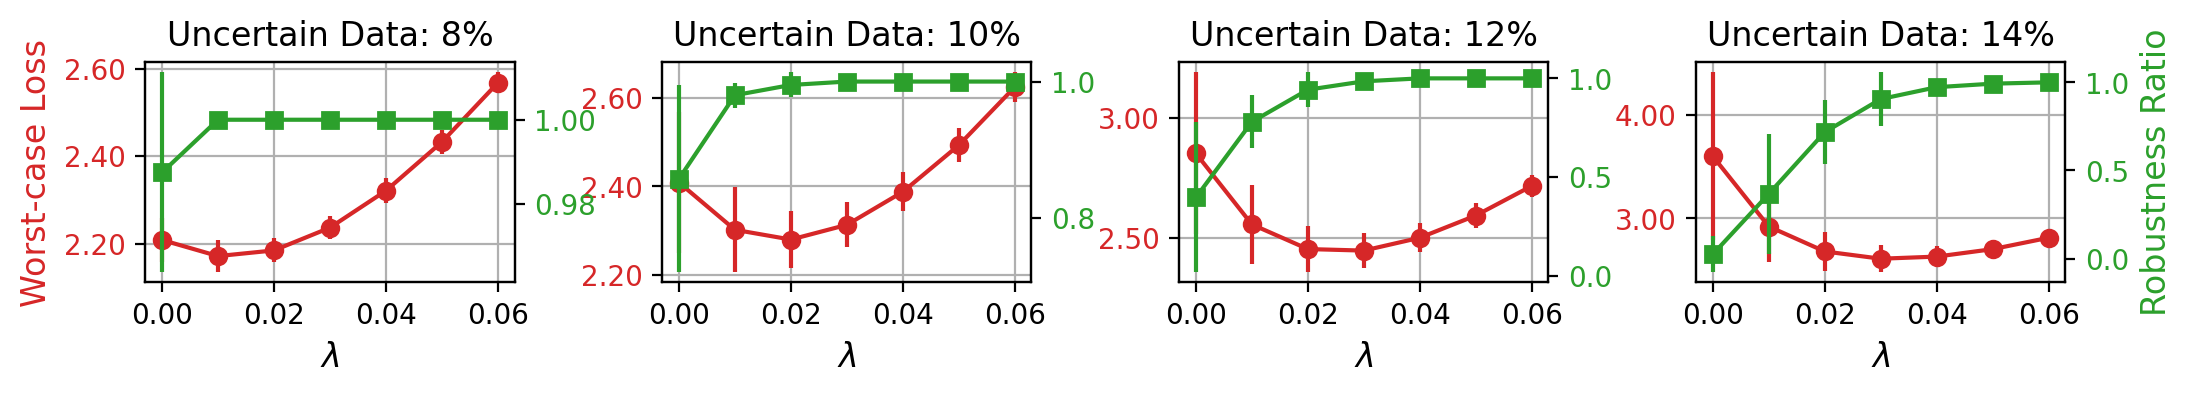

In [17]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)
color1 = 'tab:red'
color2 = 'tab:green'

for i in range(4):
    ax1 = axes[i]
    ax1.set_xlabel('$\lambda$', fontsize=12)
    if i==0:
        ax1.set_ylabel('Worst-case Loss', color=color1, fontsize=12)
    ax1.errorbar(regs, max_mse_zonotope_mean.iloc[:, i].values,
                 yerr=3*max_mse_zonotope_std.iloc[:, i],
                 color=color1, marker='o', linestyle='-')
#     ax1.plot(regs, pd.DataFrame(max_mse_dict)[uncertain_pcts[i]], color=color1, marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()

    if i==3:
        ax2.set_ylabel('Robustness Ratio', color=color2, fontsize=12)
    ax2.errorbar(regs, robustness_ratio_zonotope_mean.iloc[:, i].values,
                 yerr=3*robustness_ratio_zonotope_std.iloc[:, i],
                 color=color2, marker='s', linestyle='-')
#     ax2.plot(regs, (pd.DataFrame(robustness_ratio_dict))[uncertain_pcts[i]], color=color2, marker='s')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f'Uncertain Data: {int(uncertain_pcts[i]*100)}%')
    ax1.grid(True)
#     ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
plt.subplots_adjust(wspace=0.4, top=0.8, bottom=0.25, left=0.1, right=0.9)

plt.savefig('mpg-regularization-features-3sigma-lineplot.pdf', bbox_inches='tight')


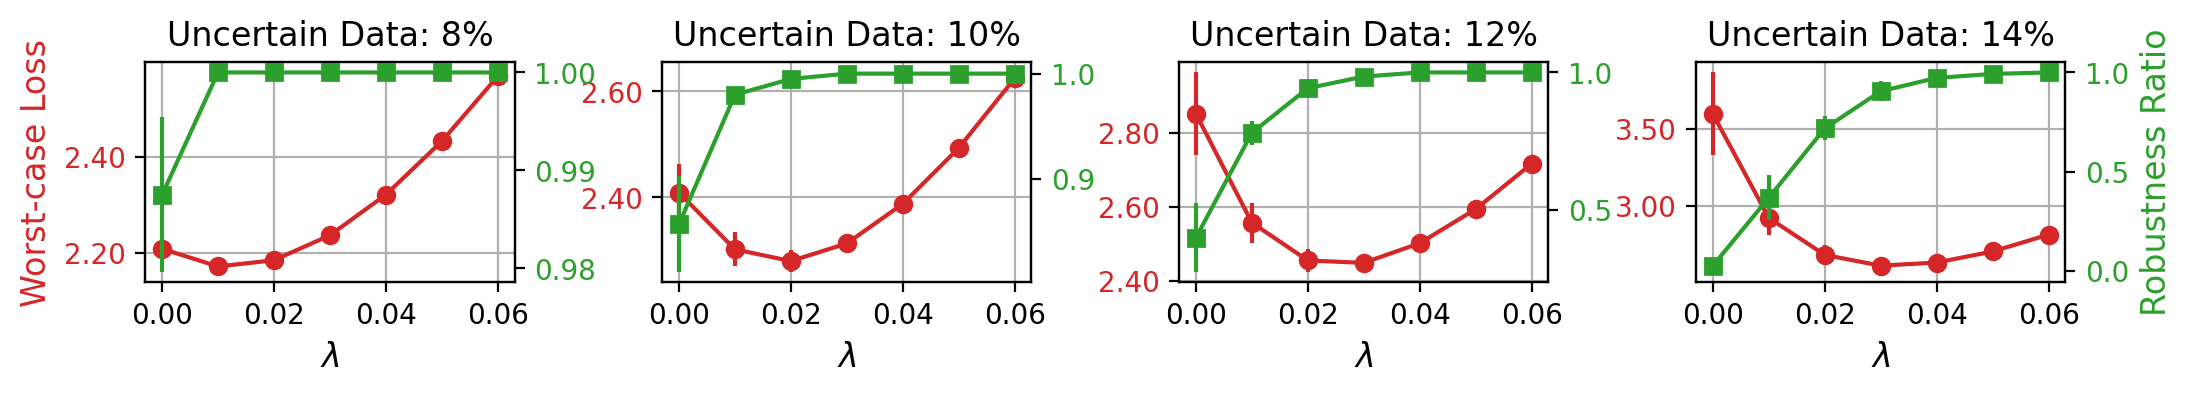

In [18]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)
color1 = 'tab:red'
color2 = 'tab:green'

for i in range(4):
    ax1 = axes[i]
    ax1.set_xlabel('$\lambda$', fontsize=12)
    if i==0:
        ax1.set_ylabel('Worst-case Loss', color=color1, fontsize=12)
    ax1.errorbar(regs, max_mse_zonotope_mean.iloc[:, i].values,
                 yerr=max_mse_zonotope_std.iloc[:, i],
                 color=color1, marker='o', linestyle='-')
#     ax1.plot(regs, pd.DataFrame(max_mse_dict)[uncertain_pcts[i]], color=color1, marker='o')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()

    if i==3:
        ax2.set_ylabel('Robustness Ratio', color=color2, fontsize=12)
    ax2.errorbar(regs, robustness_ratio_zonotope_mean.iloc[:, i].values,
                 yerr=robustness_ratio_zonotope_std.iloc[:, i],
                 color=color2, marker='s', linestyle='-')
#     ax2.plot(regs, (pd.DataFrame(robustness_ratio_dict))[uncertain_pcts[i]], color=color2, marker='s')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f'Uncertain Data: {int(uncertain_pcts[i]*100)}%')
    ax1.grid(True)
#     ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
plt.subplots_adjust(wspace=0.4, top=0.8, bottom=0.25, left=0.1, right=0.9)

plt.savefig('mpg-regularization-features-1sigma-lineplot.pdf', bbox_inches='tight')
